<a href="https://colab.research.google.com/github/muharyaanandas/Text-Mining-Viva.co.id/blob/main/Mini%20Projects%20Text%20Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Analisis Klasifikasi Kategori Pada Portal Berita [Viva.co.id](https://www.viva.co.id/) Berbahasa Indonesia Menggunakan Algoritma Naive Bayes Classfier

Kelompok B3 - Kelas B

1.   Muhammad Arya Ananda S (60200121032)
2.   Akidatul Izza (60200121118)
3.   Susilawati (60200121124)





# Menyiapkan Library

In [ ]:
# Instal paket yang diperlukan
!pip install requests beautifulsoup4 pandas scikit-learn
!pip install Sastrawi
!pip install nltk
!pip install wordcloud
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Library yang dibutuhkan
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# User-Agent header for requests
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

In [ ]:
# Download stopwords NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Proses Crawling Data

In [ ]:
def bersihkan_teks(teks):
    # Mengganti beberapa spasi berturut-turut dengan satu spasi
    teks = re.sub(r'\s+', ' ', teks)
    # Mengganti karakter newline dengan spasi
    teks = re.sub(r'\n', ' ', teks)
    # Menghapus URL dari teks
    teks = re.sub(r'http\S+', '', teks)
    # Menghapus semua karakter kecuali huruf, angka, dan spasi
    teks = re.sub(r'[^a-zA-Z0-9\s]', '', teks)
    # Menghapus spasi di awal dan akhir teks
    return teks.strip()

def fetch_article_content(session, article_url):
    # Mengambil halaman artikel
    article_page = session.get(article_url)
    article_soup = BeautifulSoup(article_page.text, 'html.parser')
    # Mencari div yang berisi konten utama artikel
    content_div = article_soup.find('div', class_='main-content-detail')
    if content_div:
        # Mengambil dan membersihkan teks artikel
        article_content = content_div.get_text(separator=' ', strip=True)
        return bersihkan_teks(article_content)
    return None

def fetch_limited_news_from_section(base_url, category, max_articles=50):
    articles_data = []
    fetched_urls = set()
    page_number = 1

    with requests.Session() as session:
        session.headers.update(headers)
        # Menggunakan ThreadPoolExecutor untuk paralelisasi
        with ThreadPoolExecutor(max_workers=10) as executor:

            while len(articles_data) < max_articles:
                # Mengambil halaman pencarian
                request_url = f"{base_url}&page={page_number}"
                response = session.get(request_url)
                if response.status_code != 200:
                    break

                page_soup = BeautifulSoup(response.text, 'html.parser')
                # Mencari div artikel di halaman pencarian
                articles = page_soup.find_all('div', class_='article-list-row')

                if not articles:
                    break  # Keluar dari loop jika tidak ada artikel yang ditemukan di halaman ini

                futures = []
                for article in articles:
                    if len(articles_data) >= max_articles:
                        break

                    link_tag = article.find('a')
                    if not link_tag:
                        continue
                    article_url = link_tag['href']
                    if not article_url.startswith('https://'):
                        article_url = 'https://www.viva.co.id' + article_url

                    if article_url in fetched_urls:
                        continue  # Melewati artikel ini jika sudah diambil

                    fetched_urls.add(article_url)  # Menambahkan URL ke set
                    futures.append(executor.submit(fetch_article_content, session, article_url))

                for future in futures:
                    try:
                        article_content = future.result()
                        if article_content:
                            articles_data.append((article_content, category.capitalize()))
                    except Exception as e:
                        continue

                page_number += 1

    return articles_data

In [ ]:
# URL dari viva.co.id (Teknologi) dan (Ekonomi)
base_url_technology = 'https://www.viva.co.id/search?q=Teknologi'
base_url_economy = 'https://www.viva.co.id/search?q=Ekonomi'

# Mengambil artikel berita dari kategori teknologi dan ekonomi, masing-masing dibatasi hingga 50 artikel
technology_news = fetch_limited_news_from_section(base_url_technology, 'teknologi', max_articles=50)
economy_news = fetch_limited_news_from_section(base_url_economy, 'ekonomi', max_articles=50)

# Penggabungan data berita
all_news_data = technology_news + economy_news
df_news = pd.DataFrame(all_news_data, columns=['content', 'class'])

In [ ]:
# Simpan data ke CSV
df_news.to_csv('hasil_crawling.csv', index=False)

# Verifikasi jumlah artikel yang diambil
print(f'Total artikel berita: {len(df_news)}')
print(df_news.head(100))  # Menampilkan baris

Total artikel berita: 100
                                              content      class
0   Jakarta  Seiring dengan rencana Pemerintah dal...  Teknologi
1   TANGERANG  Setiap pasangan mendambakan bisa me...  Teknologi
2   VIVA  APCI Asosiasi Produsen Cat Indonesia ber...  Teknologi
3   VIVA  Menyandang visi menjadi institusi kepabe...  Teknologi
4   Jakarta  Direktur Information Technology BTN A...  Teknologi
..                                                ...        ...
95  Banyuwangi  VIVA Banyuwangi Mengecek ketersedi...    Ekonomi
96  Cianjur  Dalam ajang Pemilihan Gubernur Jawa B...    Ekonomi
97  Siap  Wapres terpilih Gibran Rakabuming Raka  ...    Ekonomi
98  Gresik VIVA Jatim Menyambut tahun baru Islam 1...    Ekonomi
99  Padang  Era digital membuka banyak peluang bar...    Ekonomi

[100 rows x 2 columns]


# Data Cleaning

In [ ]:
# Data cleaning
df_news['cleaned_content'] = df_news['content'].apply(bersihkan_teks)

# Tampilkan hasil data cleaning
print("Hasil Data Cleaning :")
cleaning = df_news[['content', 'cleaned_content']]
display(cleaning.head(10))

Hasil Data Cleaning :


,content,cleaned_content
0,Jakarta Seiring dengan rencana Pemerintah dal...,Jakarta Seiring dengan rencana Pemerintah dala...
1,TANGERANG Setiap pasangan mendambakan bisa me...,TANGERANG Setiap pasangan mendambakan bisa men...
2,VIVA APCI Asosiasi Produsen Cat Indonesia ber...,VIVA APCI Asosiasi Produsen Cat Indonesia berh...
3,VIVA Menyandang visi menjadi institusi kepabe...,VIVA Menyandang visi menjadi institusi kepabea...
4,Jakarta Direktur Information Technology BTN A...,Jakarta Direktur Information Technology BTN An...
5,VIVA Di era perkembangan teknologi dan revolu...,VIVA Di era perkembangan teknologi dan revolus...
6,Jakarta Penelitian yang dilakukan di Universi...,Jakarta Penelitian yang dilakukan di Universit...
7,VIVA Belakangan ini Yamaha gencar merilis mot...,VIVA Belakangan ini Yamaha gencar merilis moto...
8,Jakarta 4 Juli 2024 Dalam sebuah langkah besa...,Jakarta 4 Juli 2024 Dalam sebuah langkah besar...
9,Jakarta Persaingan mobil di kelas Low Multi P...,Jakarta Persaingan mobil di kelas Low Multi Pu...


# Normalisasi

In [ ]:
# Tabel normalisasi untuk mengganti kata-kata tidak baku
normalization_dict = {
    " ": " ",
}

def normalisasi(teks):
    return ' '.join([normalization_dict.get(word, word) for word in teks.split()])

df_news['normalization'] = df_news['cleaned_content'].apply(normalisasi)

# Tampilkan hasil normalisasi
print("Hasil Normalisasi ")

normalisasi = df_news[['content', 'class', 'cleaned_content', 'normalization']]
display(normalisasi.head(10))

Hasil Normalisasi 


,content,class,cleaned_content,normalization
0,Jakarta Seiring dengan rencana Pemerintah dal...,Teknologi,Jakarta Seiring dengan rencana Pemerintah dala...,Jakarta Seiring dengan rencana Pemerintah dala...
1,TANGERANG Setiap pasangan mendambakan bisa me...,Teknologi,TANGERANG Setiap pasangan mendambakan bisa men...,TANGERANG Setiap pasangan mendambakan bisa men...
2,VIVA APCI Asosiasi Produsen Cat Indonesia ber...,Teknologi,VIVA APCI Asosiasi Produsen Cat Indonesia berh...,VIVA APCI Asosiasi Produsen Cat Indonesia berh...
3,VIVA Menyandang visi menjadi institusi kepabe...,Teknologi,VIVA Menyandang visi menjadi institusi kepabea...,VIVA Menyandang visi menjadi institusi kepabea...
4,Jakarta Direktur Information Technology BTN A...,Teknologi,Jakarta Direktur Information Technology BTN An...,Jakarta Direktur Information Technology BTN An...
5,VIVA Di era perkembangan teknologi dan revolu...,Teknologi,VIVA Di era perkembangan teknologi dan revolus...,VIVA Di era perkembangan teknologi dan revolus...
6,Jakarta Penelitian yang dilakukan di Universi...,Teknologi,Jakarta Penelitian yang dilakukan di Universit...,Jakarta Penelitian yang dilakukan di Universit...
7,VIVA Belakangan ini Yamaha gencar merilis mot...,Teknologi,VIVA Belakangan ini Yamaha gencar merilis moto...,VIVA Belakangan ini Yamaha gencar merilis moto...
8,Jakarta 4 Juli 2024 Dalam sebuah langkah besa...,Teknologi,Jakarta 4 Juli 2024 Dalam sebuah langkah besar...,Jakarta 4 Juli 2024 Dalam sebuah langkah besar...
9,Jakarta Persaingan mobil di kelas Low Multi P...,Teknologi,Jakarta Persaingan mobil di kelas Low Multi Pu...,Jakarta Persaingan mobil di kelas Low Multi Pu...


# PreProcessing Data

In [ ]:
# Load dataset
data = pd.read_csv('/content/hasil_crawling.csv')

Case Folding

In [ ]:
# Case folding
data['case_folding'] = data['content'].str.lower()

# Display results
print("Case Folding:\n", data[['content', 'case_folding']].head(10))

Case Folding:
                                              content  \
0  VIVA  Di era perkembangan teknologi dan revolu...   
1  Jakarta  Penelitian yang dilakukan di Universi...   
2  VIVA  Belakangan ini Yamaha gencar merilis mot...   
3  Jakarta 4 Juli 2024  Dalam sebuah langkah besa...   
4  Jakarta  Persaingan mobil di kelas Low Multi P...   
5  VIVA Tekno  PT Jakarta Infrastruktur Propertin...   
6  VIVA  Usaha Asosiasi Inventor Indonesia AII me...   
7  VIVA Tekno  Foldable phone atau ponsel lipat a...   
8  Tokyo  Jepang mulai mengedarkan uang kertas ba...   
9  VIVA Tekno  Dalam era digital yang semakin maj...   

                                        case_folding  
0  viva  di era perkembangan teknologi dan revolu...  
1  jakarta  penelitian yang dilakukan di universi...  
2  viva  belakangan ini yamaha gencar merilis mot...  
3  jakarta 4 juli 2024  dalam sebuah langkah besa...  
4  jakarta  persaingan mobil di kelas low multi p...  
5  viva tekno  pt jakarta infrastruktu

Tokenizing

In [ ]:
# Tokenizing
data['tokens'] = data['case_folding'].apply(lambda x: word_tokenize(x))

# Display results
print("\nTokenizing:\n", data[['content', 'tokens']].head(10))


Tokenizing:
                                              content  \
0  VIVA  Di era perkembangan teknologi dan revolu...   
1  Jakarta  Penelitian yang dilakukan di Universi...   
2  VIVA  Belakangan ini Yamaha gencar merilis mot...   
3  Jakarta 4 Juli 2024  Dalam sebuah langkah besa...   
4  Jakarta  Persaingan mobil di kelas Low Multi P...   
5  VIVA Tekno  PT Jakarta Infrastruktur Propertin...   
6  VIVA  Usaha Asosiasi Inventor Indonesia AII me...   
7  VIVA Tekno  Foldable phone atau ponsel lipat a...   
8  Tokyo  Jepang mulai mengedarkan uang kertas ba...   
9  VIVA Tekno  Dalam era digital yang semakin maj...   

                                              tokens  
0  [viva, di, era, perkembangan, teknologi, dan, ...  
1  [jakarta, penelitian, yang, dilakukan, di, uni...  
2  [viva, belakangan, ini, yamaha, gencar, merili...  
3  [jakarta, 4, juli, 2024, dalam, sebuah, langka...  
4  [jakarta, persaingan, mobil, di, kelas, low, m...  
5  [viva, tekno, pt, jakarta, infrastru

Lemmatization

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Display results
print("\nLemmatization:\n", data[['content', 'lemmatized']].head(10))


Lemmatization:
                                              content  \
0  VIVA  Di era perkembangan teknologi dan revolu...   
1  Jakarta  Penelitian yang dilakukan di Universi...   
2  VIVA  Belakangan ini Yamaha gencar merilis mot...   
3  Jakarta 4 Juli 2024  Dalam sebuah langkah besa...   
4  Jakarta  Persaingan mobil di kelas Low Multi P...   
5  VIVA Tekno  PT Jakarta Infrastruktur Propertin...   
6  VIVA  Usaha Asosiasi Inventor Indonesia AII me...   
7  VIVA Tekno  Foldable phone atau ponsel lipat a...   
8  Tokyo  Jepang mulai mengedarkan uang kertas ba...   
9  VIVA Tekno  Dalam era digital yang semakin maj...   

                                          lemmatized  
0  [viva, di, era, perkembangan, teknologi, dan, ...  
1  [jakarta, penelitian, yang, dilakukan, di, uni...  
2  [viva, belakangan, ini, yamaha, gencar, merili...  
3  [jakarta, 4, juli, 2024, dalam, sebuah, langka...  
4  [jakarta, persaingan, mobil, di, kelas, low, m...  
5  [viva, tekno, pt, jakarta, infras

Stopword

In [ ]:
# Stopword removal
stop_words = set(stopwords.words('indonesian'))

# Menghapus stopwords setelah lemmatization
data['stopword'] = data['lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])

# Display results
print("\nStopword Removal:\n", data[['content', 'stopword']].head(10))


Stopword Removal:
                                              content  \
0  VIVA  Di era perkembangan teknologi dan revolu...   
1  Jakarta  Penelitian yang dilakukan di Universi...   
2  VIVA  Belakangan ini Yamaha gencar merilis mot...   
3  Jakarta 4 Juli 2024  Dalam sebuah langkah besa...   
4  Jakarta  Persaingan mobil di kelas Low Multi P...   
5  VIVA Tekno  PT Jakarta Infrastruktur Propertin...   
6  VIVA  Usaha Asosiasi Inventor Indonesia AII me...   
7  VIVA Tekno  Foldable phone atau ponsel lipat a...   
8  Tokyo  Jepang mulai mengedarkan uang kertas ba...   
9  VIVA Tekno  Dalam era digital yang semakin maj...   

                                            stopword  
0  [viva, era, perkembangan, teknologi, revolusi,...  
1  [jakarta, penelitian, university, of, warwick,...  
2  [viva, yamaha, gencar, merilis, motor, pasar, ...  
3  [jakarta, 4, juli, 2024, langkah, pembangunan,...  
4  [jakarta, persaingan, mobil, kelas, low, multi...  
5  [viva, tekno, pt, jakarta, inf

In [ ]:
final_output = data[['content', 'case_folding', 'tokens', 'lemmatized', 'stopword']]
display(final_output.head(10))

,content,case_folding,tokens,lemmatized,stopword
0,VIVA Di era perkembangan teknologi dan revolu...,viva di era perkembangan teknologi dan revolu...,"[viva, di, era, perkembangan, teknologi, dan, ...","[viva, di, era, perkembangan, teknologi, dan, ...","[viva, era, perkembangan, teknologi, revolusi,..."
1,Jakarta Penelitian yang dilakukan di Universi...,jakarta penelitian yang dilakukan di universi...,"[jakarta, penelitian, yang, dilakukan, di, uni...","[jakarta, penelitian, yang, dilakukan, di, uni...","[jakarta, penelitian, university, of, warwick,..."
2,VIVA Belakangan ini Yamaha gencar merilis mot...,viva belakangan ini yamaha gencar merilis mot...,"[viva, belakangan, ini, yamaha, gencar, merili...","[viva, belakangan, ini, yamaha, gencar, merili...","[viva, yamaha, gencar, merilis, motor, pasar, ..."
3,Jakarta 4 Juli 2024 Dalam sebuah langkah besa...,jakarta 4 juli 2024 dalam sebuah langkah besa...,"[jakarta, 4, juli, 2024, dalam, sebuah, langka...","[jakarta, 4, juli, 2024, dalam, sebuah, langka...","[jakarta, 4, juli, 2024, langkah, pembangunan,..."
4,Jakarta Persaingan mobil di kelas Low Multi P...,jakarta persaingan mobil di kelas low multi p...,"[jakarta, persaingan, mobil, di, kelas, low, m...","[jakarta, persaingan, mobil, di, kelas, low, m...","[jakarta, persaingan, mobil, kelas, low, multi..."
5,VIVA Tekno PT Jakarta Infrastruktur Propertin...,viva tekno pt jakarta infrastruktur propertin...,"[viva, tekno, pt, jakarta, infrastruktur, prop...","[viva, tekno, pt, jakarta, infrastruktur, prop...","[viva, tekno, pt, jakarta, infrastruktur, prop..."
6,VIVA Usaha Asosiasi Inventor Indonesia AII me...,viva usaha asosiasi inventor indonesia aii me...,"[viva, usaha, asosiasi, inventor, indonesia, a...","[viva, usaha, asosiasi, inventor, indonesia, a...","[viva, usaha, asosiasi, inventor, indonesia, a..."
7,VIVA Tekno Foldable phone atau ponsel lipat a...,viva tekno foldable phone atau ponsel lipat a...,"[viva, tekno, foldable, phone, atau, ponsel, l...","[viva, tekno, foldable, phone, atau, ponsel, l...","[viva, tekno, foldable, phone, ponsel, lipat, ..."
8,Tokyo Jepang mulai mengedarkan uang kertas ba...,tokyo jepang mulai mengedarkan uang kertas ba...,"[tokyo, jepang, mulai, mengedarkan, uang, kert...","[tokyo, jepang, mulai, mengedarkan, uang, kert...","[tokyo, jepang, mengedarkan, uang, kertas, per..."
9,VIVA Tekno Dalam era digital yang semakin maj...,viva tekno dalam era digital yang semakin maj...,"[viva, tekno, dalam, era, digital, yang, semak...","[viva, tekno, dalam, era, digital, yang, semak...","[viva, tekno, era, digital, maju, perangkat, e..."


# Visualisasi Label

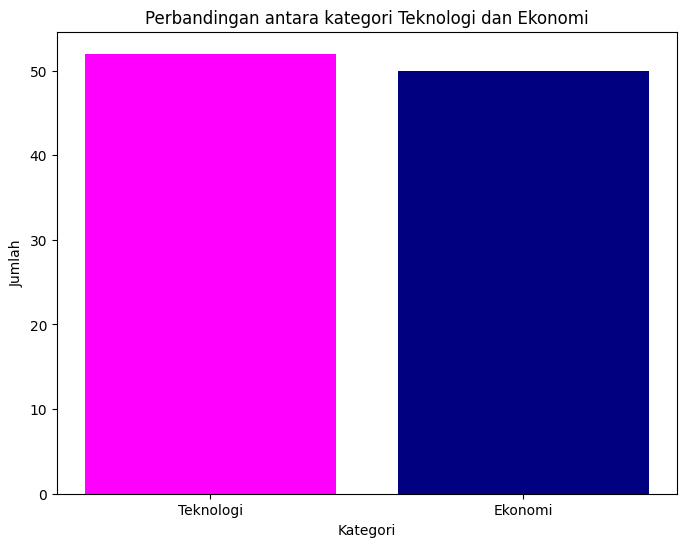

In [ ]:
# Visualisasi label "Teknologi dan Ekonomi"
category_counts = data['class'].value_counts()
categories = category_counts.index
counts = category_counts.values

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['#FF00FF','#000080'])
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.title('Perbandingan antara kategori Teknologi dan Ekonomi')
plt.show()

# Word Cloud

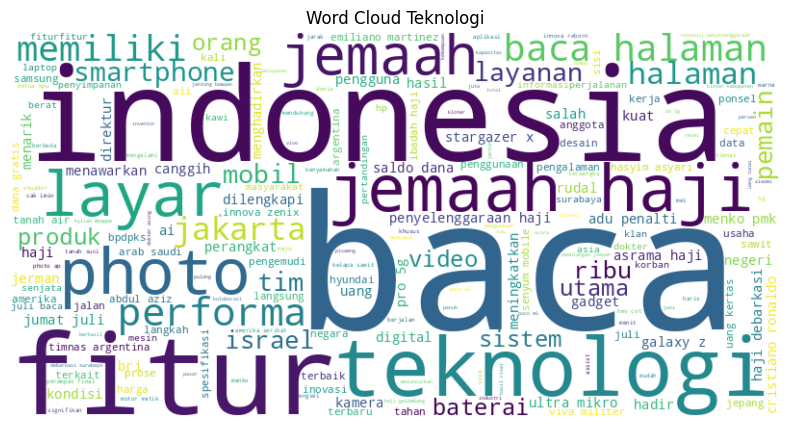

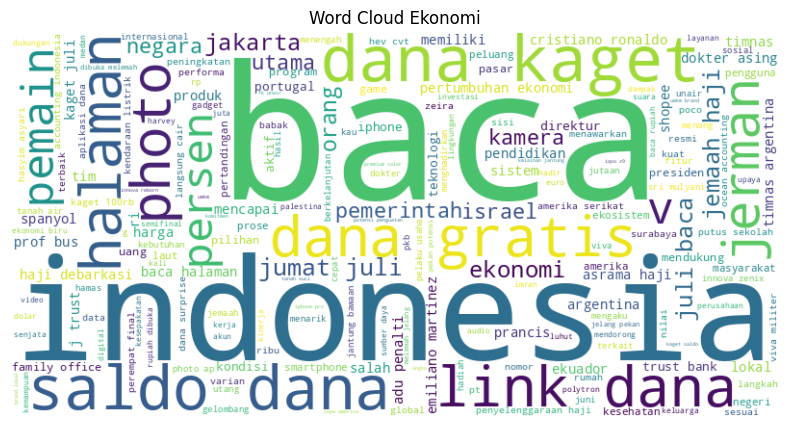

In [ ]:
# Word Cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Gabungkan semua kata-kata dalam kategori 'Teknologi' dan 'Ekonomi'
teknologi_text = ' '.join([' '.join(words) for words in data[data['class'] == 'Teknologi']['stopword']])
ekonomi_text = ' '.join([' '.join(words) for words in data[data['class'] == 'Ekonomi']['stopword']])

# Generate word cloud untuk setiap kategori
generate_wordcloud(teknologi_text, 'Word Cloud Teknologi')
generate_wordcloud(ekonomi_text, 'Word Cloud Ekonomi')

# Klasifikasi Algoritma Naive Bayes Classfier

Melatih Model

In [ ]:
# Gabungkan kata kembali menjadi string untuk TF-IDF
data['stopword_text'] = data['stopword'].apply(lambda x: ' '.join(x))

# Remove empty documents
data = data[data['stopword_text'].str.strip() != '']

# TF-IDF dengan tambahan filter
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=1, max_df=0.95)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['stopword_text'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['class'], test_size=0.1, random_state=0)

# Menggunakan SMOTE untuk menyeimbangkan dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning untuk Naive Bayes
param_grid_nb = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid_search_nb.fit(X_train_res, y_train_res)

# Model Naive Bayes terbaik
best_nb = grid_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)

Evaluasi Model

MultinomialNB Accuracy: 0.73
MultinomialNB Precision: 0.76
MultinomialNB Recall: 0.73
MultinomialNB f1_score: 0.74
confusion_matrix:
[[6 2]
 [1 2]]
              precision    recall  f1-score   support

     Ekonomi       0.86      0.75      0.80         8
   Teknologi       0.50      0.67      0.57         3

    accuracy                           0.73        11
   macro avg       0.68      0.71      0.69        11
weighted avg       0.76      0.73      0.74        11



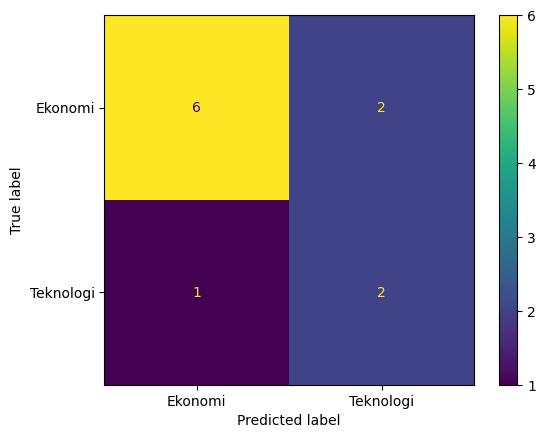

In [ ]:
# Evaluate Naive Bayes classifier
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = classification_report(y_test, y_pred_nb, output_dict=True)['weighted avg']['precision']
recall_nb = classification_report(y_test, y_pred_nb, output_dict=True)['weighted avg']['recall']
f1_nb = classification_report(y_test, y_pred_nb, output_dict=True)['weighted avg']['f1-score']
cm_nb = confusion_matrix(y_test, y_pred_nb)

print(f"MultinomialNB Accuracy: {accuracy_nb:.2f}")
print(f"MultinomialNB Precision: {precision_nb:.2f}")
print(f"MultinomialNB Recall: {recall_nb:.2f}")
print(f"MultinomialNB f1_score: {f1_nb:.2f}")
print("confusion_matrix:")
print(cm_nb)
print("=============================================================")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix Display
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=best_nb.classes_)
disp_nb.plot()
plt.show()